# DataverseNL Analysis at UM

---

https://pydataverse.readthedocs.io/

In [1]:
#!pip install -U pyDataverse == 3.1

In [2]:
import pandas as pd
from pyDataverse.api import NativeApi, DataAccessApi
from pyDataverse.models import Dataverse
import requests

In [3]:
# You need a token from Dataverse and put it on a txt file in this folder
with open('TOKEN.txt', 'r') as file:
    API_TOKEN = file.read().strip()

In [4]:
DATAVERSE = 'https://dataverse.nl/dataverse/maastricht'

In [5]:
from pyDataverse.api import NativeApi

BASE_URL = DATAVERSE.split('/dataverse/')[0]
DATAVERSE_ID = DATAVERSE.split('/dataverse/')[1]

api = NativeApi(BASE_URL, API_TOKEN)

resp = api.get_info_version()
if resp.json()['status'] == 'OK':
    print('Successful connection to DataverseNL API!!')

Successful connection to DataverseNL API!!


In [6]:
# Get list of sub-dataverses within the parent dataverse (dump in file to don't work in memory all the time)

# import json

# tree = api.get_children(DATAVERSE_ID, children_types=['dataverses','datasets'])

# with open('data/dataverse_tree.json', 'w') as f:
#     json.dump(tree, f)

In [7]:
import json

with open('data/dataverse_tree.json', 'r') as f:
    # Load the JSON data into a Python list
    tree = json.load(f)

In [8]:
def get_datasets(dataverse):
    dataverse_id = dataverse['dataverse_id']
    headers = {"X-Dataverse-key": API_TOKEN}
    url = f"{BASE_URL}/api/dataverses/{dataverse_id}/contents"
    response = requests.get(url, headers=headers)
    response_json = response.json()

    # Check if 'data' key exists in the response
    if 'data' not in response_json:
        print(f"Data key not found in response for dataverse_id {dataverse_id}")
        return {'data': []}  # Return an empty list for 'data' key

    return response_json

In [9]:
# This is DACS from FSE
#tree[5]['children'][1]

#Usage get_datasets(tree[1])

In [10]:
# Loop through sub-dataverses and get datasets and department information

datasets_list = []
for faculty in tree:
    if faculty['type'] != 'dataverse':
        continue
    faculty_name = faculty['title']
    has_departments = False
    for department in faculty['children']:
        if department['type'] != 'dataverse':
            continue
        has_departments = True
        department_name = department['title']
        datasets = get_datasets(department)
        for dataset in datasets['data']:
            publicationDate = dataset.get('publicationDate')
            if publicationDate is None:
                continue
            persistent_url = dataset.get('persistentUrl')
            if persistent_url is None:
                continue
            dataset_info = {
                'faculty': faculty_name,
                'department': department_name,
                'year': publicationDate[0:4],
                'date': publicationDate,
                'persistentUrl': persistent_url
            }
            datasets_list.append(dataset_info)
    if not has_departments:
        # Create a temporary department name
        department_name = 'No department'
        datasets = get_datasets(faculty)
        for dataset in datasets['data']:
            publicationDate = dataset.get('publicationDate')
            if publicationDate is None:
                continue
            persistent_url = dataset.get('persistentUrl')
            if persistent_url is None:
                continue
            dataset_info = {
                'faculty': faculty_name,
                'department': department_name,
                'year': publicationDate[0:4],
                'date': publicationDate,
                'persistentUrl': persistent_url
            }
            datasets_list.append(dataset_info)

df = pd.DataFrame(datasets_list)

Data key not found in response for dataverse_id 25264
Data key not found in response for dataverse_id 309780


In [11]:
len(df) # The number of datasets is Published (620) - Draft (105) - Unpublished (99)- Deaccessioned (2) - In Review (2) #CHECKED ON 12 MARCH 2023 CORRECT!!

420

In [12]:
# Create the dictionary to map the original faculty names to the new tags
faculty_dict = {'Faculty of Psychology and Neuroscience': 'FPN',
                'Faculty of Business and Economics': 'SBE',
                'Faculty of Health, Medicine and Life Sciences': 'FHML',
                'Faculty of Arts and Social Sciences': 'FASoS',
                'Faculty of Law': 'FdR',
                'Faculty of Science and Engineering': 'FSE',
                'UNU-MERIT': 'UNU-MERIT',
                'DataHub': 'DataHub & MUMC+',
                'Maastricht UMC+': 'DataHub & MUMC+'}

# Replace the original faculty names with the new tags
df.faculty = df.faculty.replace(faculty_dict)

In [13]:
df.head()

,faculty,department,year,date,persistentUrl
0,FPN,Clinical Psychological Science,2014,2014-08-13,https://doi.org/10.34894/CTDUVD
1,FPN,Clinical Psychological Science,2014,2014-03-12,https://doi.org/10.34894/9EXOFE
2,FPN,Clinical Psychological Science,2014,2014-05-26,https://doi.org/10.34894/FFCOKX
3,FPN,Clinical Psychological Science,2014,2014-12-24,https://doi.org/10.34894/AVBSW9
4,FPN,Clinical Psychological Science,2014,2014-02-27,https://doi.org/10.34894/QA0WSV


In [19]:
# Create DataFrame and group by department and year
df['count'] = 1
df_grouped = df.groupby(['faculty', 'year'])['count'].sum()

# Pivot the table to show years as columns
df_pivot = df_grouped.reset_index().pivot(index='faculty', columns='year', values='count').fillna(0)

# Calculate relative percentages
df_relative = df_pivot.apply(lambda x: round(x / x.sum() * 100,2), axis=1)

df_relative.to_excel('data/dataverse_relative.xlsx')

In [20]:
# Create DataFrame and group by department and year ABSOLUT
df['count'] = 1
df_grouped = df.groupby(['faculty', 'year'])['count'].sum()

# Pivot the table to show years as columns
df_pivot = df_grouped.reset_index().pivot(index='faculty', columns='year', values='count').fillna(0)

# Calculate relative percentages
df_absolute = df_pivot.apply(lambda x: round(x,2), axis=1)

df_absolute.to_excel('data/dataverse_absolute.xlsx')

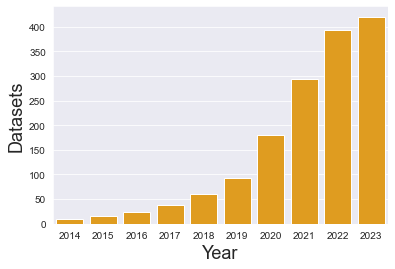

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid") #darkgrid, whitegrid, dark, white, and ticks

# Group the data by year and get the counts
counts = df.groupby('year').size().reset_index(name='count')

# Calculate the cumulative sum of counts
counts['cumulative'] = counts['count'].cumsum()

# Create a bar plot of cumulative counts by year
sns.barplot(x='year', y='cumulative', data=counts, color='orange') #steelblue

# Set the x and y-axis labels
plt.xlabel('Year', fontsize=18)
plt.ylabel('Datasets', fontsize=18)

plt.savefig('plots/runningTotal.png', dpi=300, bbox_inches='tight')

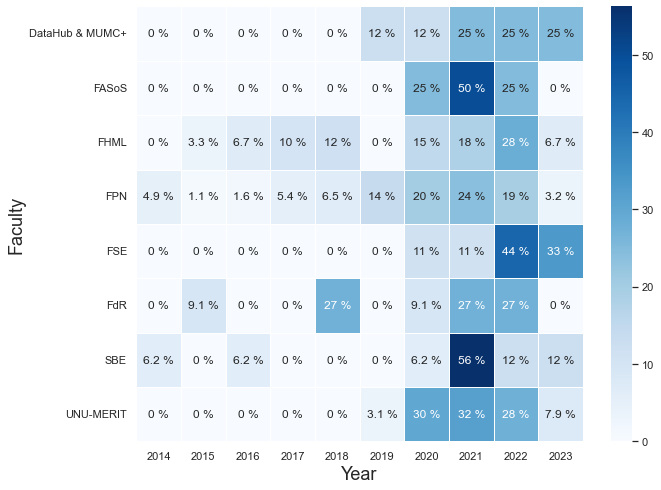

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom blue colormap
cmap = sns.color_palette("Blues", as_cmap=True)

# Set the font size for the plot
sns.set(font_scale=1)

# Create the heatmap using Seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_relative, cmap=cmap, annot=True, linewidths=0.5, ax=ax) #fmt='%.2f%%', 
for t in ax.texts: t.set_text(t.get_text() + " %")

# Set the x and y-axis labels
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('Faculty', fontsize=18)

# Save the plot as a PNG file
plt.savefig('plots/heatmapRelative.png', dpi=300, bbox_inches='tight')
